# Benodigde libraries importeren

In [47]:
import pandas as pd
from datetime import datetime
import numpy as np
import pandas.api.types as ptypes


# Bestand inladen en data filteren

In [48]:
# excel bestand maxilia geimporteerd en kolommen gefilterd 

df = pd.read_csv(r'/Users/lisannepeeters/expdata 20190912 1002.csv', sep=None, delimiter=None, engine='python', usecols=['email','Orderdate','OrderID','TurnoverLead', 'BuyinLead', 'LeadPhase','LeadStatus'])
df.head()

,OrderID,Orderdate,email,TurnoverLead,BuyinLead,LeadPhase,LeadStatus
0,27654,22-4-2014,janneke.van.wingerden@hotmail.com,840.0,0.0,Order,Gefactureerd
1,30777,9-4-2015,marloessanders@izit.nl,300.0,0.0,Order,Gefactureerd
2,32291,30-7-2014,info@ferox-design.com,235.0,0.0,Order,Gefactureerd
3,32291,30-7-2014,info@ferox-design.com,235.0,0.0,Order,Gefactureerd
4,33824,27-5-2016,johan@thermservice.be,0.0,0.0,Order,Gefactureerd


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273322 entries, 0 to 273321
Data columns (total 7 columns):
OrderID         273322 non-null int64
Orderdate       131183 non-null object
email           272921 non-null object
TurnoverLead    273322 non-null float64
BuyinLead       273322 non-null float64
LeadPhase       273322 non-null object
LeadStatus      271268 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 14.6+ MB


In [50]:
# lege rijen 'NaT' eruit gefilterd 
# Email bevat @ controle

df = df.dropna(axis=0, how = 'any', inplace=False)
df = df[~df['email'].str.contains('@')==False]
df.head()

,OrderID,Orderdate,email,TurnoverLead,BuyinLead,LeadPhase,LeadStatus
0,27654,22-4-2014,janneke.van.wingerden@hotmail.com,840.0,0.0,Order,Gefactureerd
1,30777,9-4-2015,marloessanders@izit.nl,300.0,0.0,Order,Gefactureerd
2,32291,30-7-2014,info@ferox-design.com,235.0,0.0,Order,Gefactureerd
3,32291,30-7-2014,info@ferox-design.com,235.0,0.0,Order,Gefactureerd
4,33824,27-5-2016,johan@thermservice.be,0.0,0.0,Order,Gefactureerd


In [51]:
df['Orderdate']=pd.to_datetime(df['Orderdate'], format='%d-%m-%Y')


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130990 entries, 0 to 273321
Data columns (total 7 columns):
OrderID         130990 non-null int64
Orderdate       130990 non-null datetime64[ns]
email           130990 non-null object
TurnoverLead    130990 non-null float64
BuyinLead       130990 non-null float64
LeadPhase       130990 non-null object
LeadStatus      130990 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 8.0+ MB


In [53]:
df.describe()

,OrderID,TurnoverLead,BuyinLead
count,130990.000000,130990.000000,130990.000000
mean,149361.316788,831.791600,501.835442
std,60978.915532,2564.755128,1918.010058
min,27654.000000,-392.000000,-1001.510000
25%,95896.250000,183.000000,44.500000
50%,150672.500000,355.000000,177.300000
75%,203525.000000,765.000000,448.450000
max,252808.000000,174519.500000,141338.840000


In [54]:
# Leadphase = order
# Leadstatus = gefactureerd
df = df[~df['LeadPhase'].str.contains('Order')==False]
df = df[~df['LeadStatus'].str.contains('Gefactureerd')==False]
df.head()

,OrderID,Orderdate,email,TurnoverLead,BuyinLead,LeadPhase,LeadStatus
0,27654,2014-04-22,janneke.van.wingerden@hotmail.com,840.0,0.0,Order,Gefactureerd
1,30777,2015-04-09,marloessanders@izit.nl,300.0,0.0,Order,Gefactureerd
2,32291,2014-07-30,info@ferox-design.com,235.0,0.0,Order,Gefactureerd
3,32291,2014-07-30,info@ferox-design.com,235.0,0.0,Order,Gefactureerd
4,33824,2016-05-27,johan@thermservice.be,0.0,0.0,Order,Gefactureerd


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120174 entries, 0 to 272752
Data columns (total 7 columns):
OrderID         120174 non-null int64
Orderdate       120174 non-null datetime64[ns]
email           120174 non-null object
TurnoverLead    120174 non-null float64
BuyinLead       120174 non-null float64
LeadPhase       120174 non-null object
LeadStatus      120174 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 7.3+ MB


In [56]:
# Check data bevat voldoet aan bepaalde condities
assert ptypes.is_datetime64_any_dtype(df['Orderdate'])
assert all(df[df['email'].str.contains('@')])
assert all(df[df['LeadPhase'].str.contains('Order')])
assert all(df[df['LeadStatus'].str.contains('Gefactureerd')])


# Data grouperen per klant

In [57]:
# group by customer ID
# hoeveel orders zijn er gedaan per customer
# totale uitgaven per customer 

df_clv = df.groupby('email').agg({
                                                        'Orderdate': lambda date: (date.max() - date.min()).days,
                                                        'OrderID': lambda num: len(num), 
                                                        'TurnoverLead': lambda price: price.sum()
                                                    }) 
df_clv.head()

,Orderdate,OrderID,TurnoverLead
email,,,
-,0,1,2727.5
03vichy@gmail.com,0,1,259.0
06alexisbrunet@gmail.com,0,1,180.0
070paulus070@gmail.com,0,1,33.5
1.NLD.MINUSMA.GAO.AHDET.COGP.S1@B-SC1.TTN.MINDEF.NL,0,1,1230.5


In [12]:
# rename kolommen 

df_clv.columns = ['days_customer', 'total_transactions', 'total_spent']
df_clv.head()

,days_customer,total_transactions,total_spent
email,,,
03vichy@gmail.com,0,1,259.0
06alexisbrunet@gmail.com,0,1,180.0
070paulus070@gmail.com,0,1,33.5
1.NLD.MINUSMA.GAO.AHDET.COGP.S1@B-SC1.TTN.MINDEF.NL,0,1,1230.5
1.vorsitzende.gv.muenster@gmail.com,0,2,689.0


In [13]:
df_clv.describe()

,days_customer,total_transactions,total_spent
count,67777.000000,67777.000000,6.777700e+04
mean,76.580684,1.773050,1.422681e+03
std,225.263499,2.678135,1.018020e+04
min,0.000000,1.000000,-7.840000e+02
25%,0.000000,1.000000,1.770000e+02
50%,0.000000,1.000000,3.505000e+02
75%,0.000000,2.000000,8.950000e+02
max,1686.000000,177.000000,1.974618e+06


# Berekenen van de totale CLV

In [14]:
# gemiddelde order waarde 

avg_order_value = sum(df_clv['total_spent']) / sum(df_clv['total_transactions'])
print(avg_order_value)

802.3922652531487


In [15]:
# hoe vaak koopt iemand gemiddeld iets

purchase_frequency = sum(df_clv['total_transactions']) / df_clv.shape[0]
print(purchase_frequency)

1.7730498546704634


In [16]:
# hoe vaak komt iemand terug

repeat_rate = df_clv[df_clv.total_transactions > 1].shape[0] / df_clv.shape[0] 
print(repeat_rate)

0.2944804284639332


In [17]:
# churnrate: hoeveel % doet na 1 aankoop geen bestelling meer

churn_rate = 1 - repeat_rate
print(churn_rate)

0.7055195715360668


In [18]:
# gemiddelde marge  

profit = sum(df['TurnoverLead']) - sum(df['BuyinLead'])
margin = profit / sum(df['TurnoverLead'])
    
print(margin)

0.4000812090561646


In [19]:
# totale clv & clv marge 
# in het blok hierboven is de marge berekend ('margin'), maar je kan ook een getal noteren ipv 'margin'

total_clv = (avg_order_value * purchase_frequency) / churn_rate 
total_clv_margin = total_clv * margin

print(total_clv) # het eerste getal is de totale clv
print(total_clv_margin) # het tweede getal is de clv waarbij rekening is gehouden met de berekende marge

2016.501804759743
806.764480112216


In [20]:
# Bovenstaande cijfers in kolom neerzetten zodat de data in datastudio kan worden gebruikt
set_total_clv = avg_order_value, purchase_frequency, churn_rate, total_clv, total_clv_margin 
df_total_clv = pd.DataFrame(set_total_clv, columns= ['Waarde'], index = ['Gemiddelde orderwaarde' , 'Frequentie aankoop', 'Churn rate' , 'CLV', 'CLV marge'])
df_clv_values=df_total_clv.T.groupby(level=0).agg(lambda x : x.values.tolist()).stack().apply(pd.Series).unstack().sort_index(level=1,axis=1)
df_clv_values.columns=df_clv_values.columns.droplevel(level=0)
df_clv_values.head()

,CLV,CLV marge,Churn rate,Frequentie aankoop,Gemiddelde orderwaarde
Waarde,2016.501805,806.76448,0.70552,1.77305,802.392265


In [21]:
df_clv_values.to_excel('CLV_waardes.xlsx')

   # Transacties en churn rate per maand uiteenzetten

In [22]:
# transacties per klant per maand uiteenzetten
df_monthly = df.set_index('Orderdate')
df_monthly = df_monthly.pivot_table(
    index=['email'],
    columns=pd.Grouper(freq='M'),
    values='OrderID', 
    aggfunc='count',
    fill_value=0
)

# Format column headers to human readable format
df_monthly.columns = [x.strftime('%b-%Y') for x in df_monthly.columns]

df_monthly

,Apr-2014,Jul-2014,Sep-2014,Oct-2014,Nov-2014,Dec-2014,Jan-2015,Feb-2015,Mar-2015,Apr-2015,...,Dec-2018,Jan-2019,Feb-2019,Mar-2019,Apr-2019,May-2019,Jun-2019,Jul-2019,Aug-2019,Sep-2019
email,,,,,,,,,,,,,,,,,,,,,
03vichy@gmail.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06alexisbrunet@gmail.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
070paulus070@gmail.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1.NLD.MINUSMA.GAO.AHDET.COGP.S1@B-SC1.TTN.MINDEF.NL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.vorsitzende.gv.muenster@gmail.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.vs@ogv-asperg.de,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111856@student.drenthecollege.nl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1187@nl.mcd.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1206admin@nl.mcd.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [23]:
repeat_rate = df_monthly[df_monthly > 1].count() / df_monthly[df_monthly > 0].count()
df_churn = repeat_rate.to_frame(name='repeat_rate')

In [24]:
df_churn['churn_rate'] = 1 - df_churn['repeat_rate']
df_churn


,repeat_rate,churn_rate
Apr-2014,0.000000,1.000000
Jul-2014,1.000000,0.000000
Sep-2014,0.000000,1.000000
Oct-2014,0.333333,0.666667
Nov-2014,0.222222,0.777778
Dec-2014,0.157895,0.842105
Jan-2015,0.113941,0.886059
Feb-2015,0.125000,0.875000
Mar-2015,0.142680,0.857320
Apr-2015,0.146650,0.853350


# CLV per klant uitrekenen

In [25]:
# clv per customer

df_clv['customer_order_value'] = df_clv['total_spent'] / df_clv['total_transactions']
df_clv['customer_clv'] = (df_clv['customer_order_value'] * purchase_frequency) / churn_rate
df_clv['customer_clv_margin'] = df_clv['customer_clv'] * margin

df_clv.head()

,days_customer,total_transactions,total_spent,customer_order_value,customer_clv,customer_clv_margin
email,,,,,,
03vichy@gmail.com,0,1,259.0,259.0,650.896064,260.411284
06alexisbrunet@gmail.com,0,1,180.0,180.0,452.360199,180.980815
070paulus070@gmail.com,0,1,33.5,33.5,84.189259,33.682541
1.NLD.MINUSMA.GAO.AHDET.COGP.S1@B-SC1.TTN.MINDEF.NL,0,1,1230.5,1230.5,3092.384583,1237.204963
1.vorsitzende.gv.muenster@gmail.com,0,2,689.0,344.5,865.767159,346.377172


In [26]:
df_clv.describe()

,days_customer,total_transactions,total_spent,customer_order_value,customer_clv,customer_clv_margin
count,67777.000000,67777.000000,6.777700e+04,67777.000000,67777.000000,67777.000000
mean,76.580684,1.773050,1.422681e+03,548.221568,1377.742319,551.208813
std,225.263499,2.678135,1.018020e+04,1049.502799,2637.518307,1055.221513
min,0.000000,1.000000,-7.840000e+02,-392.000000,-985.139989,-394.135998
25%,0.000000,1.000000,1.770000e+02,163.000000,409.637291,163.888183
50%,0.000000,1.000000,3.505000e+02,290.700000,730.561722,292.284017
75%,0.000000,2.000000,8.950000e+02,574.560000,1443.933755,577.690763
max,1686.000000,177.000000,1.974618e+06,61600.000000,154807.712577,61935.656819


In [27]:
df_clv.to_excel('CLV_per_klant.xlsx')

In [28]:
# Uiteenzetting uitgaves klanten per maand
df['month_yr'] = df['Orderdate'].apply(lambda x: x.strftime('%b-%Y'))
df.head()

,OrderID,Orderdate,email,TurnoverLead,BuyinLead,LeadPhase,LeadStatus,month_yr
0,27654,2014-04-22,janneke.van.wingerden@hotmail.com,840.0,0.0,Order,Gefactureerd,Apr-2014
1,30777,2015-04-09,marloessanders@izit.nl,300.0,0.0,Order,Gefactureerd,Apr-2015
2,32291,2014-07-30,info@ferox-design.com,235.0,0.0,Order,Gefactureerd,Jul-2014
3,32291,2014-07-30,info@ferox-design.com,235.0,0.0,Order,Gefactureerd,Jul-2014
4,33824,2016-05-27,johan@thermservice.be,0.0,0.0,Order,Gefactureerd,May-2016


In [29]:
#totale transacties / opbrengst per maand

df_transacties = df.groupby('month_yr').aggregate({
                                                        'OrderID': lambda num: len(num), 
                                                        'TurnoverLead': lambda price: price.sum(),
                                                        'email': pd.Series.nunique
                                                    }) 
df_transacties.head()

,OrderID,TurnoverLead,email
month_yr,,,
Apr-2014,1,840.00,1
Apr-2015,964,560079.82,791
Apr-2016,1394,1058527.53,1104
Apr-2017,1394,1092140.07,1070
Apr-2018,2577,2085363.70,1949


In [30]:
df_transacties.columns = ['total_transactions', 'total_spent', 'total_unique_customers']
df_transacties.head()

,total_transactions,total_spent,total_unique_customers
month_yr,,,
Apr-2014,1,840.00,1
Apr-2015,964,560079.82,791
Apr-2016,1394,1058527.53,1104
Apr-2017,1394,1092140.07,1070
Apr-2018,2577,2085363.70,1949


In [31]:
df_transacties.describe()

,total_transactions,total_spent,total_unique_customers
count,63.000000,6.300000e+01,63.000000
mean,1907.492063,1.530557e+06,1459.507937
std,1125.410318,9.606221e+05,819.342909
min,1.000000,2.190000e+02,1.000000
25%,1164.000000,8.268239e+05,931.500000
50%,1694.000000,1.357479e+06,1348.000000
75%,2623.500000,2.272373e+06,1995.500000
max,4629.000000,3.839136e+06,3538.000000


In [32]:
df_transacties.to_excel('Overzicht_per_maand.xlsx')

# CLV per maand berekenen

In [33]:
# CLV per maand berekenen
df_transacties['purchase_frequency_month'] = df_transacties['total_transactions'] / df_transacties['total_unique_customers']
df_transacties['avg_order_value_month'] = df_transacties['total_spent'] / df_transacties['total_transactions'] 
df_transacties['CLV'] = (df_transacties['avg_order_value_month'] * df_transacties['purchase_frequency_month']) / df_churn['churn_rate']
df_transacties['CLV_margin'] = df_transacties['CLV']*margin
df_transacties.head()

,total_transactions,total_spent,total_unique_customers,purchase_frequency_month,avg_order_value_month,CLV,CLV_margin
month_yr,,,,,,,
Apr-2014,1,840.00,1,1.000000,840.000000,840.000000,336.068216
Apr-2015,964,560079.82,791,1.218710,580.995664,829.747881,331.966536
Apr-2016,1394,1058527.53,1104,1.262681,759.345430,1151.825386,460.823693
Apr-2017,1394,1092140.07,1070,1.302804,783.457726,1252.454209,501.083394
Apr-2018,2577,2085363.70,1949,1.322217,809.221459,1313.201322,525.387173


# Statistieken CLV per klant

In [34]:
# statistieken van clv per customer 

import statistics

df_clv_list = df_clv['customer_clv'].values

x1 = statistics.mean(df_clv_list) # eerste getal is gemiddelde
x2 = statistics.median(df_clv_list) # tweede getal is mediaan
x3 = statistics.mode(df_clv_list) # derde getal is de modus 
x4 = statistics.stdev(df_clv_list) # vierde getal is de standaarddeviatie 

print(x1) 
print(x2) 
print(x3) 
print(x4)

1377.7423190737757
730.5617215274582
0.0
2637.518306649236


In [35]:
# box plot: visuele weergaven van de verdeling van de clv 
# zichtbaar = minimum, maximum, mediaan en kwartielafstanden 

import matplotlib.pyplot as plt 
df_clv.plot(y = 'customer_clv', kind = 'box') 
plt.show()

<Figure size 640x480 with 1 Axes>

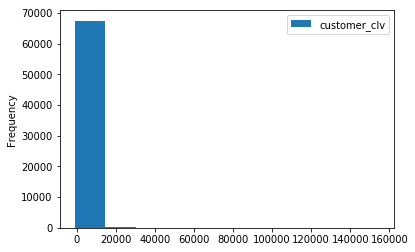

In [36]:
# histogram plot: visuele weergaven van frequentie verdeling van de clv 
# hoe vaak komt een clv waarde voor 

import matplotlib.pyplot as plt 
df_clv.plot(y = 'customer_clv', kind = 'hist') 
plt.show()